BY Srinath Sai Tripuraneni :- A20338902.

In [1]:
!pip install pyspark #installing pyspark because I used pyspark for data filteration.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark import SparkContext, SparkConf
import numpy as np                         
import matplotlib.pyplot as plt     
import math                                           #importing necessary libraries and functions.
from numpy.linalg import norm

In [3]:
sc = SparkContext("local","Assignment-4: LF Model with biases reccomendation") #initializing spark context 

In [4]:
trainRDD=sc.textFile('/content/training_dataset.csv').map(lambda x:x.split(",")) #as our datasets are in csv formatting splitting based on comma with the help of map function.


In [5]:
def take_required(x):
  required=[]
  required.append(x[0])
  required.append(x[1]) #Actually our dataset contains movie names also but for rmse that column is not required so filtering only first 3 functions.
  required.append(x[2]) #and this function is ownly defined to select first 3 columns.
  return required

In [6]:
trainRDD=trainRDD.map(lambda x : take_required(x)) #mapping every value by calling above defined function.

In [7]:
trainRDD=trainRDD.filter(lambda x : x[0]!='user_id') #in our csv file we get heading specifying which column is what. That headings are not required so filtering heading row.

In [8]:
def make_int(x):
  ans=[]
  for y in x :   #while reading into rdd,it read as text format. so this function is created to convert every row into int append them and will be sent as list.
    ans.append(int(y))
  return ans

In [9]:
trainRDD=trainRDD.map(lambda x : make_int(x)) #calling above function which converts every row into int and as a list ,so basically this
#is a rdd of list of list containg training dataset information.

In [10]:
userRDD=trainRDD.map(lambda x : (x[0])) #as first column is users taking first column from trainrdd with the help of map function.
itemsRDD=trainRDD.map(lambda x: (x[1])) #as second column is items, taking second column from trainrdd with the help of map function.
ratingsRDD=trainRDD.map(lambda x : (x[2])) #as third column is items, taking third column from trainrdd with the help of map function.
#why this step , you will understand in few minutes.

In [11]:
overal_mean_rating=ratingsRDD.mean() #taking overal_mean of ratings.

In [12]:
max_users=userRDD.max()  #extracting maximum user count means that many users are there in the given dataset at maximum.
max_items=itemsRDD.max() #extracting maximum items from items rdd means given dataset has that many items at maximum.

In [13]:
users=set(userRDD.collect())  #taking unique users.
items=set(itemsRDD.collect()) #taking unique items.

In [14]:
traindata=np.array(trainRDD.collect()) #converting trainRDD as numpy array for calculating.

In [15]:
del trainRDD
del userRDD     #deleting all rdds for memory effiency and after converting to numpy array, we won't be using rdds therefore deleting them.
del itemsRDD
del ratingsRDD

In [16]:
k=25 #given k for P and Q matrices as other dimension.
lamda =0.1 #given lamda.
iterations=40  # given iteration count.
learning_rate=0.002 #this is the challenging factor, as hyper parameter tunning is not allowed, did trial and error process many times and finally got better result of all values which is 0.002.
P = np.random.rand(max_users,k)*(np.sqrt(5/k)) #initialing P and Q matrices randomly with dimensions of max_users obtained above and max_items obtained above from 2 rdds.And values in
#range 0,rootof 5/k.
Q = np.random.rand(max_items,k)*(np.sqrt(5/k)) 
#link referedd fro intialing random numpy valuse:-
#https://stackoverflow.com/questions/26456180/initializing-a-matrix-with-random-number-from-given-range-python

In [17]:
#here for every user and for every item we will be adding biases in error and regularization so initializing user biases and item biases matices.
user_dimensions=(max_users,)
item_dimensions=(max_items,)  #dimensions will be maximum users and maximum items for both matrices.
biases_of_users=np.zeros(user_dimensions,dtype=np.int32)
biases_of_items=np.zeros(item_dimensions,dtype=np.int32) #As a first step initializing zeroes.

Actually the idea for lf model and lf model with biases is same for every iteration first we calculate P and Q values and then calculate error function with regularization. But only difference is that here we will update user biases, item biases matrix every time because these also will be updated and needs in error function. 
Therefore same code that I have coded in LF model has been used here with some modification so same steps but made code more modular for readibility.

In [18]:
#link for idea for lf model with biases. :- https://towardsdatascience.com/recsys-series-part-4-the-7-variants-of-matrix-factorization-for-collaborative-filtering-368754e4fab5

In [19]:
def initial_process(): #This is the initial process of every iteration filling P and Q and user biases matrices, item biases matrices and returning them as tuple.
  for x in traindata:
    mainpart=x[2]-(learning_rate + biases_of_users[x[0]-1] + biases_of_items[x[1]-1] + np.dot(P[x[0]-1],Q[x[1]-1]))
    biases_of_users[x[0]-1]= biases_of_users[x[0]-1] + learning_rate*(mainpart-lamda*(biases_of_users[x[0]-1]))  #filling user biases matrix, item biases matrix by gradient descent algorithm.
    biases_of_items[x[1]-1]= biases_of_items[x[1]-1] + learning_rate*(mainpart-lamda*(biases_of_items[x[1]-1]))  #and here we won't get extra part in P and Q .
    P[x[0]-1] = P[x[0]-1] + learning_rate*(2*mainpart*(Q[x[1]-1])-lamda*(P[x[0]-1])) #filling of P and Q values iteratively and this two statements are direct translation of given formulas
    Q[x[1]-1] = Q[x[1]-1] + learning_rate*(2*mainpart*(P[x[0]-1])-lamda*(Q[x[1]-1]))

  return P, Q, biases_of_users, biases_of_items


In [20]:
def regularization(): #this function is created to compute regularization for every iteration.
  p_norm=0            #this function will return user_norm,items_norm, bias_of every user and bias_of every item.
  q_norm=0
  user_bias_norm=0
  item_bias_norm=0
  for i in P:
    for j in i:
      p_norm+=(j*j)        #this nested loop calculates user_norm by row wise of P matrix(dedicated to users.)
  
  for x in Q:
    for y in x:
      q_norm+=(y*y)        #this nested loops calculates items_norm by row wise of Q matrix(dedicated to items).

  for b in range(len(biases_of_users)):
    user_bias_norm += pow(norm(biases_of_users[b]),2) #this loop calculates norm of every row of bias_of_users because in that matrix every row is a user and those biases are calculated.

  for a in range(0,len(biases_of_items)):
    item_bias_norm += pow(norm(biases_of_items),2)  #this loop calculates norm of every row of bias_of_items because in that matrix every row is a item and those biases are calculated.
    
  return p_norm,q_norm,user_bias_norm, item_bias_norm

In [21]:
def calculating_error(): #A function that is used for calculating error for every function.
  error_part=0 
  for x in traindata:
    error_part+=pow(x[2]-(learning_rate + biases_of_users[x[0]-1] + biases_of_items[x[1]-1] + np.dot(P[x[0]-1],Q[x[1]-1])),2) #here x[2] is orginal rating from numpy array of traindata and np.dot(P[x[0]-1],Q[x[1]-1]) is the product of value from P and Q for each row.
  user_norm, item_norm, users_bias, items_bias = regularization()                                                             #as biases are also present in formula accesing particular bias of users and biases of items.
  error=error_part + lamda*(user_norm + item_norm + users_bias + items_bias) #adding lamda* norms obtained above as shown in main formula.
  return error #main error with regularization is returned.

In [22]:
error_per_iteration_cache={} #a hashmap is created for storing error as value and iteration count as keys.
for i in range(0,iterations):
  P,Q,biases_of_users,biases_of_items = initial_process() #initial process of filling of P,Q,user_biases and items_biases matrices are done.
  error_per_iteration_cache[i+1] = calculating_error() #error is calculated and updated in hashmap as similar to the comment.

 

In [23]:
iteration_counts=list(error_per_iteration_cache.keys()) # taking keys of hashmap which are iterations as list.
error_per_iteration=list(error_per_iteration_cache.values()) # taking values of hashmap into other list.

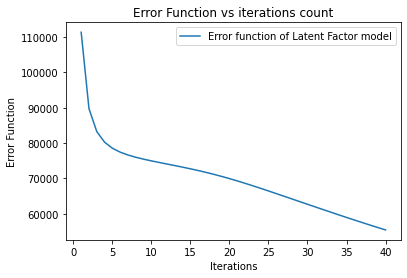

In [24]:
plt.plot(iteration_counts, error_per_iteration, label="Error function of Latent Factor model");
plt.title("Error Function vs iterations count");
plt.xlabel("Iterations"); 
plt.ylabel("Error Function");                          #graphhing between error function value per iteration vs iterations count.
plt.legend(loc=0);

In [25]:
testdataRDD=sc.textFile('/content/test_dataset.csv').map(lambda x :x.split(","))#now for preparing testdata we take it as textfile in rdd and map by splitting with comma.
testdataRDD=testdataRDD.map(lambda x: take_required(x))  
testdataRDD=testdataRDD.filter(lambda x: x[0]!='user_id') #similar to trainrdd filtering header row, and taking only first 3 columns.
testdataRDD=testdataRDD.map(lambda x: make_int(x))#making every value as int type from the above function for testdata.
testdata=np.array(testdataRDD.collect()) #converting testdata to np array for calculation.

In [26]:
user_all_ratings={user: [] for user in users} #initializing unique user as key and empty list as values.
for i in traindata:
  user_all_ratings[i[0]].append(i[2])  #this loop is madesuch that for every unique user there will be list of ratings rated by him as list and appended as value for particular user key.
average_user_rating={} #initializing a dictionary which will be user as key and average of each user rating as value.
for i in user_all_ratings: 
  average_user_rating[i]=(sum(user_all_ratings[i])/len(user_all_ratings[i])) #computing average rating for each user.


In [27]:
predicted_ratings=[]
actual_ratings=[]
for x in testdata:  # A loop to have predicted ratings, actual ratings for calculation of RMSE.
  if(x[1] not in items):                                    #this if-else block is filling of predicted ratings from either dot product of particular user from P and particular item from Q with biases
    predicted_ratings.append(average_user_rating[x[0]])     #or from hashmap of average rating of user.
  else:
    predicted_ratings.append(learning_rate + biases_of_users[x[0]-1] + biases_of_items[x[1]-1] + np.dot(P[x[0]-1],Q[x[1]-1])) 
  actual_ratings.append(x[2]) #here in testdata we take ratings to be actual ratings and it will be 2 nd element of each line from list of list from numpy array.

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt 
def RMSE(y_actual, y_predicted):                               #a inbuilt function to calculate rmses of both predicted and actual ratings.
  rms = sqrt(mean_squared_error(y_actual, y_predicted))
  return round(rms,4)

In [29]:
RMSE(actual_ratings,predicted_ratings) #calling function for calculating list of predicted and actual ratings.

0.9171

In [30]:
predicted_ratings1=[]
actual_ratings1=[]
for x in testdata:                            #this loop is taking only values from dot product of P and Q of particular user, item with biases not taking from average rating of per user implying not using any average rating per use
  predicted_ratings1.append(learning_rate + biases_of_users[x[0]-1] + biases_of_items[x[1]-1] + np.dot(P[x[0]-1],Q[x[1]-1]))
  actual_ratings1.append(x[2])

In [31]:
RMSE(actual_ratings1,predicted_ratings1) #calling again for values which have only from matrices P and Q with biases.

0.9172

I have implemented LF model with biases of same parameters used in LF model. 

IMPORTANT OBSERVATION :-Though LF with biases took more time than LF model, with LF model with biases I observe there is a little bit increse in rmse because in normal LF model rmse is 0.915 above (aprroxly), and in lf model with biases rmse is 0.915 . With better hyper tunning and proper initialization of matrixes, LF with biases will be having less rmse.

These values may change for every execution due to random intializations.